Привет, меня зовут Артем Носенко и я буду проверять твой проект.
<br>Небольшая вступительная часть и начнем работу)
<br> Если не против, то предлагаю общаться на «ты». Если это не удобно - дай знать, и мы перейдем на "вы". Моя основная цель — не указать на совершенные ошибки, а поделиться своим опытом и помочь сделать твой проект лучше. Для этого я буду использовать разный стиль оформления комментариев.
<div class="alert alert-block alert-success">
✔️ Все хорошо.
</div>

<div class="alert alert-warning">
⚠️ Критических замечаний нет, но есть возможность сделать твою работу лучше.
</div>

<div class="alert alert-block alert-danger">
❌ Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>


Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ...
</div>
Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта оперативнее».


In [2]:
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import os 
import psycopg
from implicit.als import AlternatingLeastSquares
import mlflow
import numpy as np
from threadpoolctl import threadpool_limits
import boto3

# load .env contstants
load_dotenv()

# gloabal vars upload
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") 

EXPERIMENT_NAME = "e_commerce_final"
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000
REGISTRY_MODEL_NAME = "ALS"
pip_requirements = '../config/requirements.txt'

# устанавливаем host, который будет отслеживать наши эксперименты
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# fix random seed for experiemnts reproduction
SEED = 42 
np.random.seed(seed=SEED)

connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

# Create a connection string
connection_string = (
    f"postgresql://{postgres_credentials['user']}:{postgres_credentials['password']}"
    f"@{postgres_credentials['host']}:{postgres_credentials['port']}/{postgres_credentials['dbname']}"
)

# Create a SQLAlchemy engine
engine = create_engine(connection_string)


def load(TABLE_NAME):
    connection.update(postgres_credentials)
    with psycopg.connect(**connection) as conn:
        with conn.cursor() as cur:
            cur.execute(f"SELECT * FROM {TABLE_NAME}")
            data = cur.fetchall()
            columns = [col[0] for col in cur.description]
    df = pd.DataFrame(data, columns=columns)

    return df

/home/zcemg08/projects/mle-pr-final/.env_mle_pr_final/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Импорты сделаны, отлично!
</div>

Импорты стоит располагать в отдельной ячейке и группировать по типам. Вот [тут](https://peps.python.org/pep-0008/#imports:~:text=Imports%20should%20be,library%20specific%20imports.) можно посмотреть, как в стандарте PEP8 оформляются импорты.

S3_BUCKET_NAME=s3-student-mle-20240620-7af3548300

Анализ данных электронной коммерции (вывод из этого блокнота): 

Динамика событий

1. Пользователи в основном взаимодействуют один раз (75%) и только два раза (<20%).
2. Динамика между просмотрами/действиями добавления в корзину и транзакциями коррелирует с течением времени.
3. В выходные дни наблюдается самый низкий уровень активности.
4. Динамика вовлеченности пользователей имеет сезонный характер в течение 1–2 недель.
5. 80% просмотров сосредоточено на 20% самых популярных товаров.
6. Совокупные транзакции имеют менее крутую кривизну по сравнению с просмотрами.
7. Все объекты недвижимости проверены в 3 часа ночи. 

Свойства предметов

Первые 20 наиболее распространенных свойств присутствуют в большинстве продуктов. 
Однако на объекты недвижимости с рейтингом ниже 20 приходится небольшая часть товаров.

1. Два свойства были константами.
2. Некоторые свойства были текстового типа; они будут рассмотрены позже.
3. Восьмой признак (свойство 790), по-видимому, представляет цену, что делает его лучшим кандидатом среди других в топ-15 на основе разумного распределения значений.
4. Существует 1200 уникальных идентификаторов предметов и 300 категорий.
5. Присутствует признак "доступен", что немаловажно.
6. В среднем для описания товара используется 25 свойств.


Признаки, которые можно добавить в модель после открытия EDA:

1. Цена 
2. TI-DF+SVD (текстовое описание параграфа продукта) (рекомендуется в будущем)
3. Сезонность 
4. Родительская категория в качестве кодировки метки (300 штук)
5. Категории частотного кодирования 


Моделирование:

1. Очень низкий уровень взаимодействия между пользователем и элементом -> рекомендуют категории, а не отдельные элементы.
2. ParentID слишком мал, может привести к исключению электроники 
3. Из категории раздачи удалим телевизоры, но не электронику.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Отличное описание проекта!
</div>

1. Events EDA 

In [2]:
events = load("events")
events.head(5)

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [3]:
# time format must be cahnged 
events["timestamp"] = pd.to_datetime(events['timestamp'], unit='ms')
events.set_index('timestamp', inplace=True)

In [4]:
# look for nans
events.isna().sum(),len(events)

(visitorid              0
 event                  0
 itemid                 0
 transactionid    2733644
 dtype: int64,
 2756101)

In [5]:
events[events["transactionid"].notna()]

,visitorid,event,itemid,transactionid
timestamp,,,,
2015-06-02 05:17:56.276,599528,transaction,356475,4000.0
2015-06-01 21:18:20.981,121688,transaction,15335,11117.0
2015-06-01 21:25:15.008,552148,transaction,81345,5444.0
2015-06-01 16:38:56.375,102019,transaction,150318,13556.0
2015-06-01 16:01:58.180,189384,transaction,310791,7244.0
...,...,...,...,...
2015-07-31 21:12:56.570,1050575,transaction,31640,8354.0
2015-07-31 21:57:58.779,861299,transaction,456602,3643.0
2015-07-31 15:48:50.123,855941,transaction,235771,4385.0


In [6]:
# what do non na transaction mean in terms of the event type  
events[events["transactionid"].notna()]["event"].value_counts()

event
transaction    22457
Name: count, dtype: int64

#### Идентификатор транзакции не равен нулю, когда люди совершали покупку

In [7]:
# what are the events start and end dates 
events.index.min(), events.index.max()

(Timestamp('2015-05-03 03:00:04.384000'),
 Timestamp('2015-09-18 02:59:47.788000'))

In [8]:
# duplicates  

events[events[["visitorid","event","itemid"]].duplicated()]["event"].value_counts()

event
view           532185
addtocart        7307
transaction      1187
Name: count, dtype: int64

In [9]:
# what is the fraction of the duplicated events  
(532185+7307+1187)/len(events)

0.19617532158654563

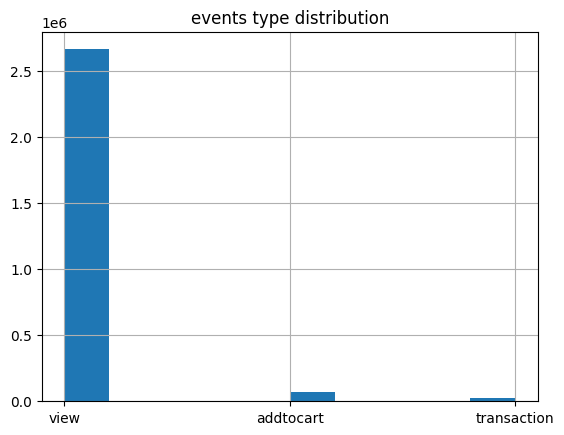

In [10]:
import matplotlib.pyplot as plt 
events["event"].hist()   
plt.title("events type distribution")
plt.savefig("../mlflow_server/assets/events_distribution.jpg")
plt.show()

#### Как и ожидалось, просмотры являются основным источником событий.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Верно!
</div>

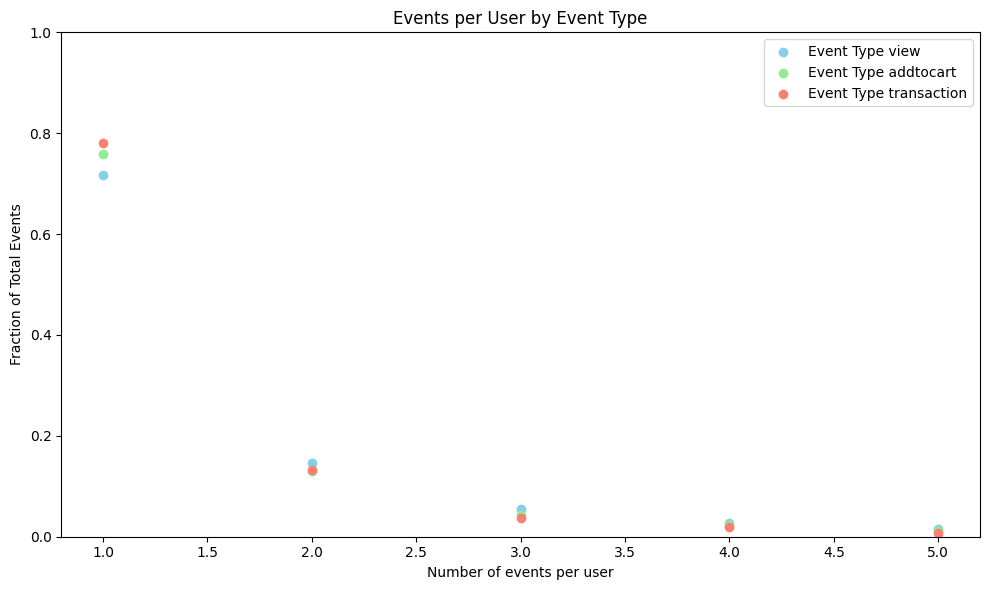

In [11]:
# Define event types to analyze
event_types = events['event'].unique()

colors = ['skyblue', 'lightgreen', 'salmon']

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each event type and plot on the same axes
for i, event_type in enumerate(event_types):
    # Filter events for the specific event type
    df_transactions = events[events["event"] == event_type]
    
    # Count transactions by visitor ID and calculate transaction counts
    transaction_counts = df_transactions.groupby("visitorid").agg("count").reset_index()["itemid"].value_counts()

    # Calculate fractions
    transaction_fractions = transaction_counts.values / transaction_counts.sum()

    # Scatter plot, assign a unique color to each event type
    ax.scatter(transaction_counts.index[:5], transaction_fractions[:5], color=colors[i], label=f'Event Type {event_type}')

# Add titles, labels, and legend
ax.set_title('Events per User by Event Type')
ax.set_xlabel('Number of events per user')
ax.set_ylabel('Fraction of Total Events')
ax.set_ylim(0, 1)  # Set y-axis limits for better visualization
ax.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("../mlflow_server/assets/events_per_user_combined.jpg")
plt.show()

#### В среднем каждый пользователь совершает 75% взаимодействий один раз и менее 20% дважды.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ События очень разряжены, верно!
</div>

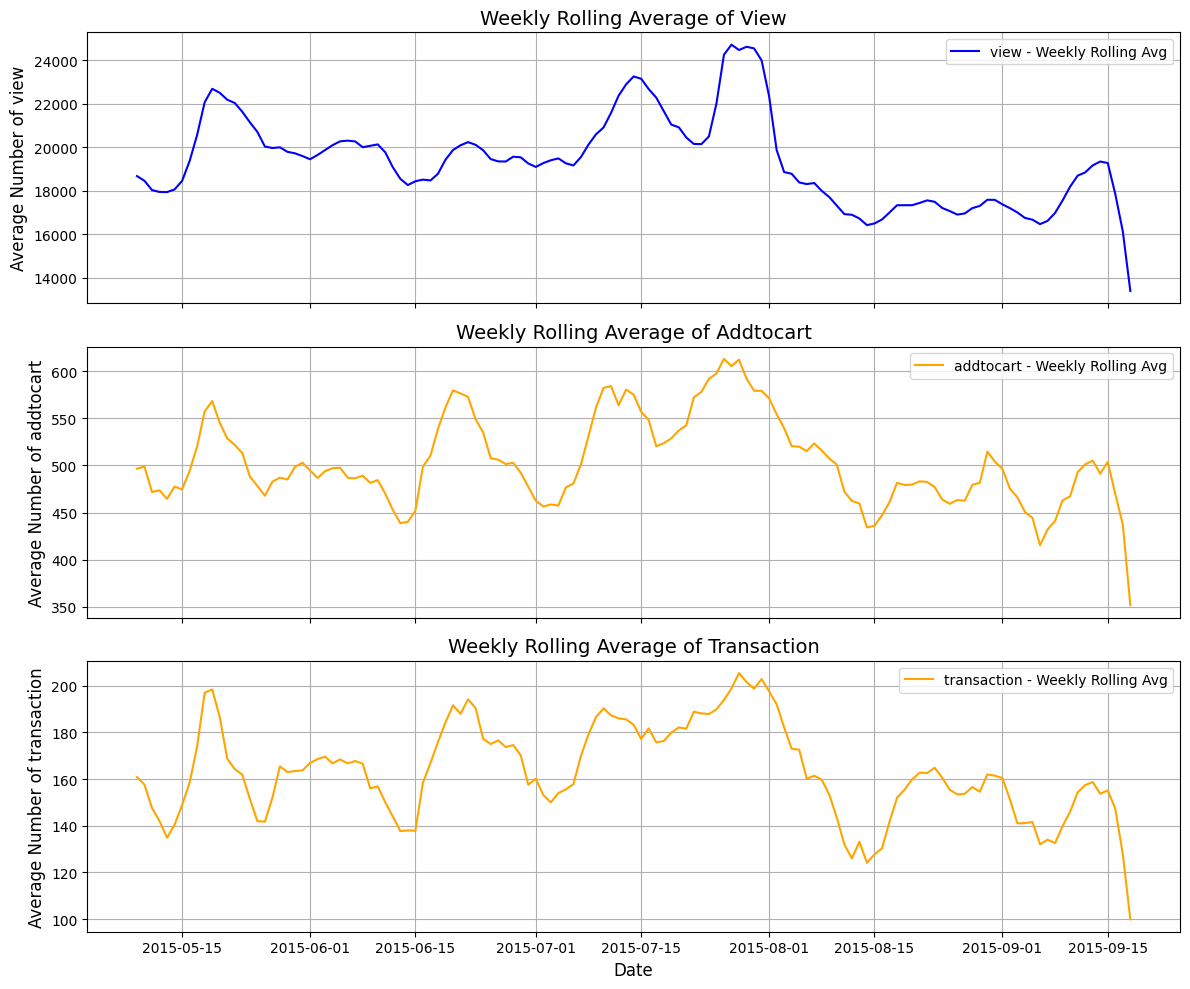

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True)

event_types = ["view", 'addtocart', 'transaction']

# Iterate through each event type and plot the weekly rolling average
for i, event_type in enumerate(event_types):
    # Filter the DataFrame for the current event type
    group = events[events['event'] == event_type]
    
    # Resample to daily frequency and count the number of events per day
    daily_event_count = group.resample('D').size()
    
    # Calculate the weekly rolling average
    weekly_rolling_avg = daily_event_count.rolling(window=7).mean()
    
    # Plot the weekly rolling average in the corresponding subplot
    axs[i].plot(weekly_rolling_avg, label=f'{event_type} - Weekly Rolling Avg', color='blue' if event_type == 'view' else 'orange')
    axs[i].set_title(f'Weekly Rolling Average of {event_type.capitalize()}', fontsize=14)
    axs[i].set_ylabel('Average Number of'+' ' + f'{event_type}', fontsize=12)
    axs[i].legend()
    axs[i].grid(True)

# Set common x-label for the bottom subplot
axs[2].set_xlabel('Date', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig("../mlflow_server/assets/user_activity_time_trend.jpg")
plt.show()

#### Просмотры, добавление в диаграмму и продажи коррелируют друг с другом 
#### Присутствует сезонность на одну и две недели

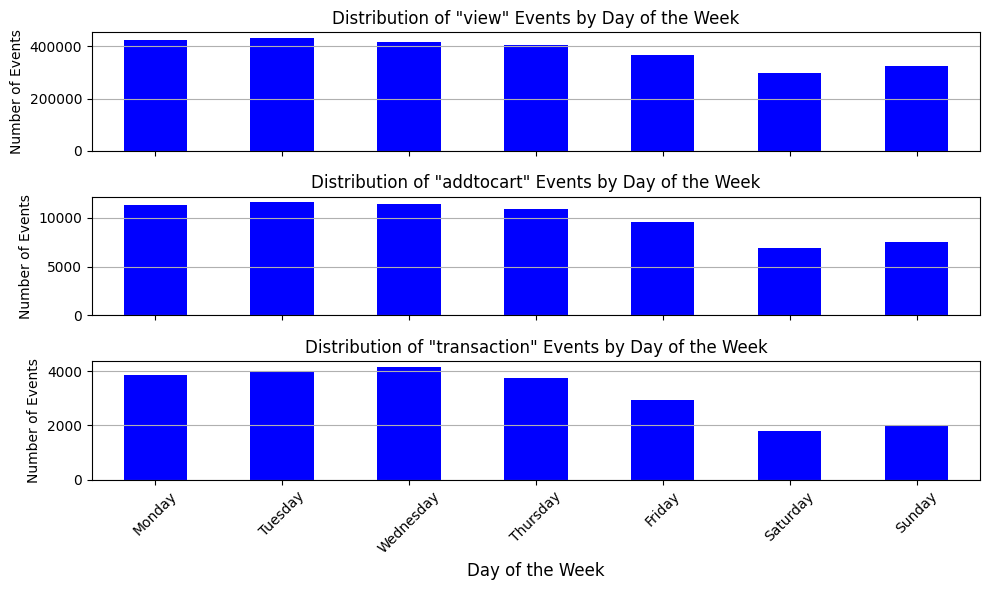

In [13]:
# Extract day of the week from the index
events['day_of_week'] = events.index.day_name()

# Create subplots for each event type
event_types = events['event'].unique()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, axes = plt.subplots(len(event_types), 1, figsize=(10, 6), sharex=True)

# Count occurrences of each event type by day of the week and plot
for ax, event in zip(axes, event_types):
    event_data = events[events['event'] == event]
    event_counts = event_data['day_of_week'].value_counts().reindex(days_order)
    event_counts.plot(kind='bar', ax=ax, color='blue')
    ax.set_title(f'Distribution of "{event}" Events by Day of the Week', fontsize=12)
    ax.set_ylabel('Number of Events', fontsize=10)
    ax.grid(axis='y')

# Set common x-label
plt.xlabel('Day of the Week', fontsize=12)
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.savefig("../mlflow_server/assets/event_distribution_by_day_of_week_subplots.jpg", bbox_inches='tight')
plt.show()

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Отличная визуализация, выводы корректные!
</div>

#### Активность пользователя наиболее снижается в выходные дни. 
#### Объем транзакций упал почти в два раза

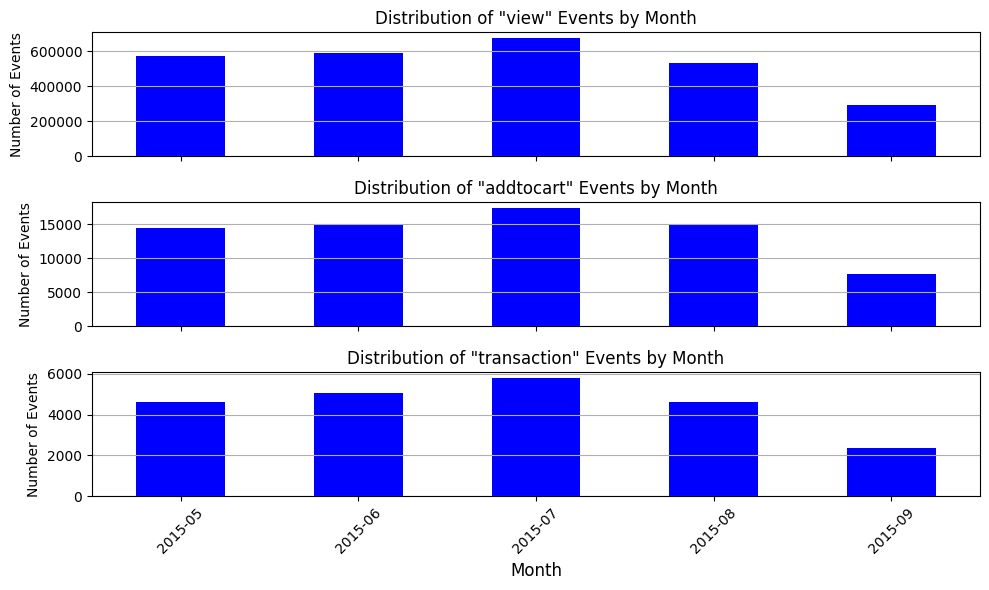

In [14]:
# Create a 'month' column for grouping
events['month'] = events.index.to_period('M')

# Create subplots for each event type
event_types = events['event'].unique()
fig, axes = plt.subplots(len(event_types), 1, figsize=(10, 6), sharex=True)

# Count occurrences of each event type by month and plot
for ax, event in zip(axes, event_types):
    event_data = events[events['event'] == event]
    event_counts = event_data['month'].value_counts().sort_index()
    event_counts.plot(kind='bar', ax=ax, color='blue')
    ax.set_title(f'Distribution of "{event}" Events by Month', fontsize=12)
    ax.set_ylabel('Number of Events', fontsize=10)
    ax.grid(axis='y')

# Set common x-label
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=45)

# Adjust layout
plt.tight_layout()
plt.savefig("../mlflow_server/assets/event_distribution_by_month_subplots.jpg", bbox_inches='tight')
plt.show()

#### 1. Ежемесячные объемы относительно стабильны
#### 2. Сентябрь показывает наименьшее значение, поскольку набор данных заканчивается 18 сентября.

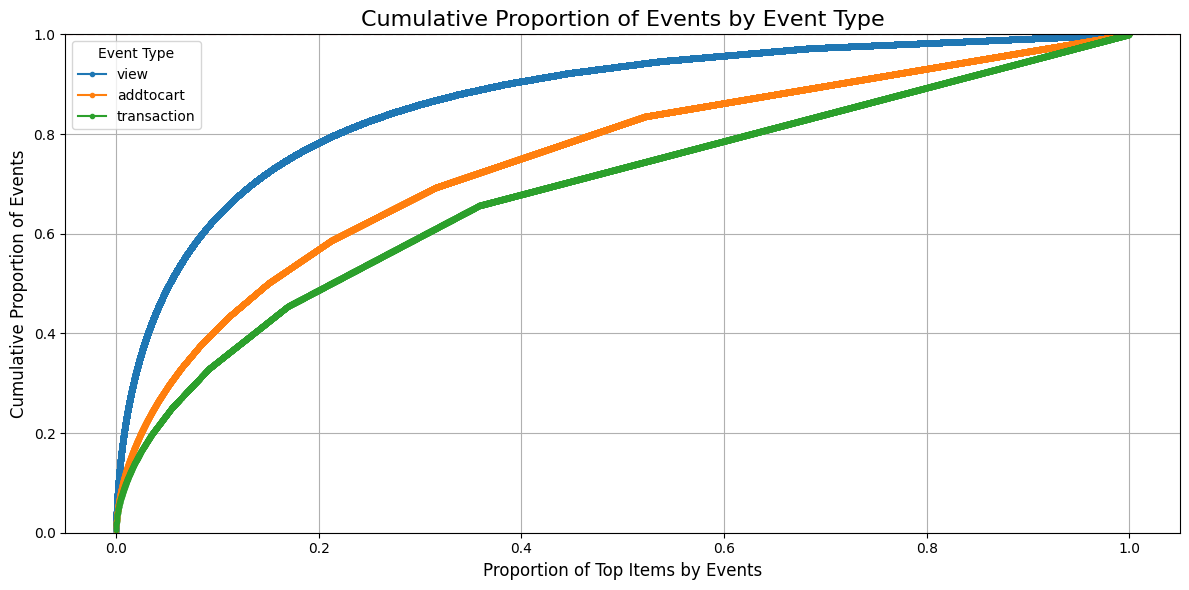

In [15]:
event_types = events['event'].unique()
dfs = {}

# Loop through each event type to calculate item counts and cumulative proportions
for event in event_types:
    item_counts = events[events['event'] == event]["itemid"].value_counts()
    df_item_counts = pd.DataFrame(item_counts.items(), columns=['itemid', 'count'])
    
    # Calculate total sales for the event
    total_sales = df_item_counts['count'].sum()

    # Sort values to identify top sold items
    df_item_counts = df_item_counts.sort_values('count', ascending=False)

    # Calculate cumulative sales and proportion
    df_item_counts['cumulative_sales'] = df_item_counts['count'].cumsum()
    df_item_counts['proportion'] = df_item_counts['cumulative_sales'] / total_sales
    
    # Create an index for the number of top sold items
    df_item_counts.loc[:, 'item_number'] = range(1, len(df_item_counts) + 1)
    
    # Store the DataFrame for each event type
    dfs[event] = df_item_counts

# Plot
plt.figure(figsize=(12, 6))

# Plot for each event type
for event, df_top_k in dfs.items():
    plt.plot(df_top_k['item_number'] / df_top_k['item_number'].max(), df_top_k['proportion'], marker='.', linestyle='-', label=event)

# Customize the plot
plt.title('Cumulative Proportion of Events by Event Type', fontsize=16)
plt.xlabel('Proportion of Top Items by Events', fontsize=12)
plt.ylabel('Cumulative Proportion of Events', fontsize=12)
plt.ylim(0, 1)  # Ensure the y-axis goes from 0 to 1
plt.grid()
plt.axhline(y=1, color='r', linestyle='--')  # Optional line at y=1 for reference
plt.legend(title='Event Type')  # Add a legend for event types
plt.tight_layout()

# Save the plot if needed
plt.savefig("../mlflow_server/assets/top_k_items_cumulative_proportion_by_event_type.jpg", bbox_inches='tight')

plt.show()

#### 20% самых популярных товаров обеспечивают 80% просмотров
#### Отношения менее ступенчаты для транзакций (представления не влияют только на транзакции)
#### Такие факторы, как цены, могут повлиять на конверсию просмотров в транзакции.

In [16]:
del events

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Выводы корректные!


# Item Properties

In [ ]:
item_properties_part1 = load("item_properties_part1")
item_properties_part2 = load("item_properties_part2")

In [ ]:
# time range in item_properties dataset 
item_properties_part1["timestamp"] =  pd.to_datetime(item_properties_part1['timestamp'], unit='ms')
item_properties_part2["timestamp"] =  pd.to_datetime(item_properties_part2['timestamp'], unit='ms')

print(item_properties_part1["timestamp"].min(),item_properties_part1["timestamp"].max(),item_properties_part2["timestamp"].min(),item_properties_part2["timestamp"].max())

# reset index for timeseries manipulations
item_properties_part1.set_index("timestamp")
item_properties_part2.set_index("timestamp")

2015-05-10 03:00:00 2015-09-13 03:00:00 2015-05-10 03:00:00 2015-09-13 03:00:00


,itemid,property,value
timestamp,,,
2015-05-31 03:00:00,183478,561,769062
2015-08-16 03:00:00,132256,976,n26.400 1135780
2015-06-28 03:00:00,420307,921,1149317 1257525
2015-05-17 03:00:00,403324,917,1204143
2015-06-28 03:00:00,230701,521,769062
...,...,...,...
2015-06-07 03:00:00,236931,929,n12.000
2015-08-30 03:00:00,455746,6,150169 639134
2015-08-16 03:00:00,347565,686,610834


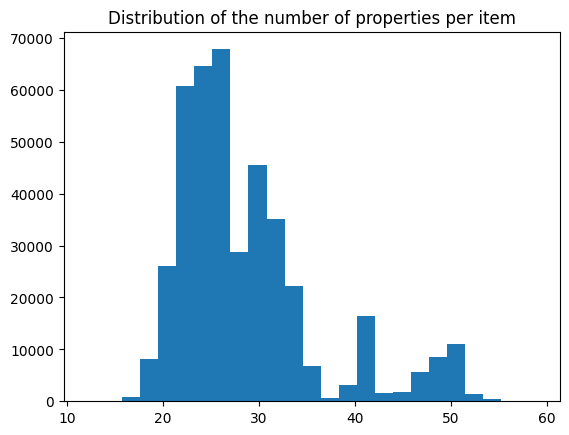

In [ ]:

df_prop = pd.concat([item_properties_part1,item_properties_part2])
items_properties = df_prop[~df_prop[["itemid","property"]].duplicated()][["itemid","property"]]
property_per_item_count = items_properties.groupby("itemid").agg("count").reset_index()
plt.hist(property_per_item_count["property"],bins=25)
plt.title("Distribution of the number of properties per item")
plt.savefig("../mlflow_server/assets/properties_per_item.jpg", bbox_inches='tight')
plt.show()

#### В описании товаров показаны 3 режима: первый включает 25 свойств, второй около 40 и последний 50.

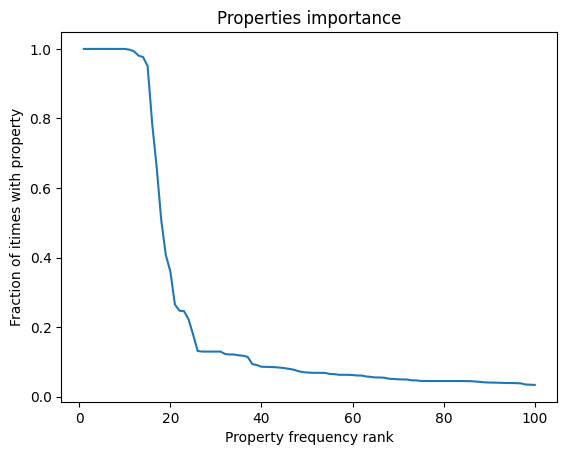

In [ ]:
property_count = df_prop[~df_prop[["itemid","property"]].duplicated()].groupby("property").agg("count").sort_values("value",ascending=False).reset_index()[["property","value"]]
n_unique_items = len(df_prop[~df_prop[["itemid","property"]].duplicated()]["itemid"].unique())
property_count["value"] = property_count["value"]/n_unique_items
plt.plot(list(range(1, 101)), property_count["value"].iloc[:100])
plt.xlabel("Property frequency rank")
plt.ylabel("Fraction of itimes with property")
plt.title("Properties importance")
plt.savefig("../mlflow_server/assets/properties_importance.jpg", bbox_inches='tight')
plt.show()

In [ ]:
print("the total number of unique properties count = {}".format(len(property_count)))

the total number of unique properties count = 1104


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ ОК!
</div>

####  Есть 15 свойств которые присудствуют в практически во всех товаров

In [ ]:
# print 25 most common properties
property_count.head(15)

,property,value
0,790,1.000000
1,764,1.000000
2,888,1.000000
3,283,1.000000
4,categoryid,1.000000
5,364,1.000000
6,available,1.000000
7,112,1.000000
8,159,1.000000
9,678,0.999918


In [ ]:
top_15_properties = property_count["property"].loc[:14]
# Saving to a txt file
file_path = '../mlflow_server/assets/top_15_properties.txt'
with open(file_path, 'w') as file:
    for property in top_15_properties:
        file.write(f"{property}\n")

Интересные свойства товаров

availability

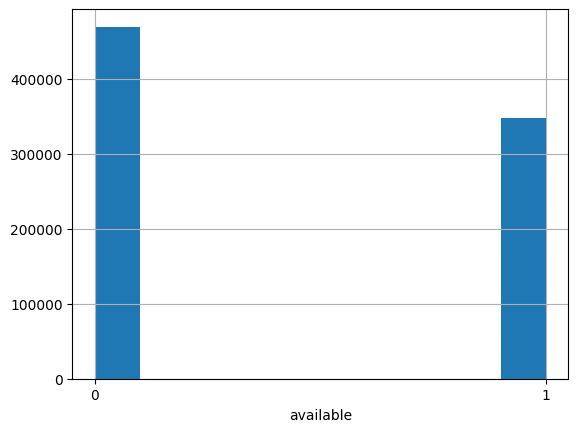

In [ ]:
# есть в продажах или нет
item_properties_part1[item_properties_part1["property"]=="available"]["value"].hist()
plt.xlabel("available")
plt.savefig("../mlflow_server/assets/available_product.jpg", bbox_inches='tight')
plt.show()

790 цена товара (лучший кандидат из 15)

In [ ]:
filtered_df = df_prop[df_prop["property"] == "790"]
filtered_df.head(5)

,timestamp,itemid,property,value
3,2015-05-10 03:00:00,59481,790,n15360.000
14,2015-06-14 03:00:00,169055,790,n21000.000
16,2015-06-28 03:00:00,178601,790,n5400.000
42,2015-05-17 03:00:00,125874,790,n39588.000
46,2015-06-07 03:00:00,272201,790,n10320.000


/tmp/ipykernel_27153/1419426603.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['numeric_value'] = filtered_df['value'].str.extract(r'(\d+\.\d+)').astype(float)


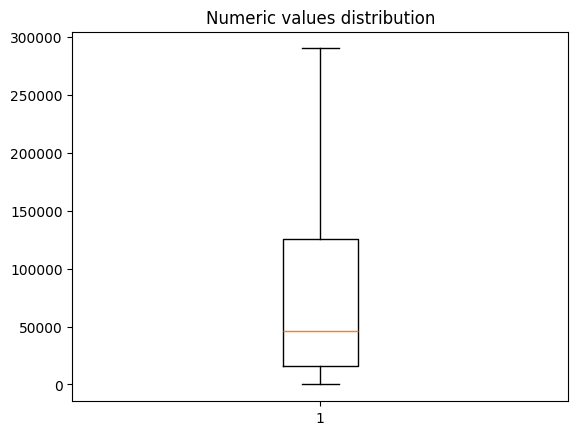

In [ ]:
# Distribution might indicate if the price numbers are unreal
filtered_df['numeric_value'] = filtered_df['value'].str.extract(r'(\d+\.\d+)').astype(float)
plt.boxplot(filtered_df['numeric_value'].values,showfliers=False)
plt.title("Numeric values distribution")
plt.savefig("../mlflow_server/assets/price_range.jpg", bbox_inches='tight')
plt.show()

283 описание товара

In [ ]:
df_prop[df_prop["property"] == "283"]["value"]

158                                     132734 242183 797785
175                                    1319279 920988 639039
309                                     554317 820477 938947
334                            882006 768453 1113872 1230005
338        341599 912235 363182 695707 479886 341599 9122...
                                 ...                        
9275765       971154 292676 1318713 864089 215470 n13872.000
9275782                  305351 322391 1120576 114320 221130
9275805    188678 1128577 227976 309875 486553 n48.000 31...
9275830                   598729 511183 981281 829153 631983
9275860    132734 718335 820527 73763 132734 1148760 8205...
Name: value, Length: 597419, dtype: object

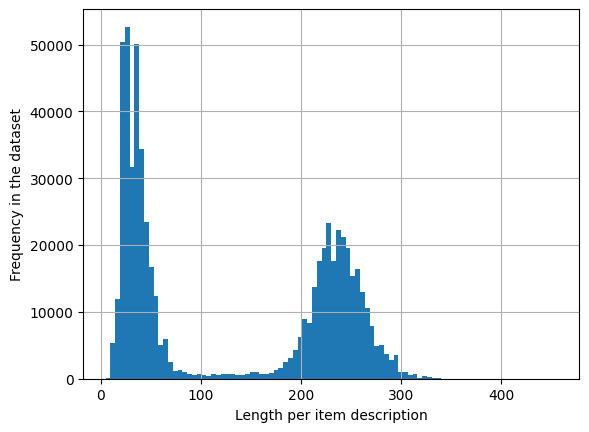

In [ ]:
df_prop[df_prop["property"] == "283"]["value"].apply(lambda x:len(x)).hist(bins="auto")
plt.xlabel("Length per item description")
plt.ylabel("Frequency in the dataset")
plt.savefig("../mlflow_server/assets/product_description.jpg", bbox_inches='tight')
plt.show()

#### Явный признак того, что это свойство представляет собой закодированное текстовое описание.

1. Длина двух мод в строке аналогична количеству слов в небольших абзацах.
2. Данные включают целочисленные записи в формате \n48.000, а остальные не содержат десятичных знаков и являются целыми числами.
3. В pandas данные сохраняются как dtype('O'), что является распространенным способом сохранения строк.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Согласен!
</div>


# Modelling 

# Перекодировка юзер айди и категорий 

рекомендовать будем категории товаров но не сами товары, так как очень слабое взаимодействие юзеров с товарами

In [3]:
from sklearn.preprocessing import LabelEncoder
# присвоим каждому товару его категорию
events = load("events")
categories = load("item_categories")
events = events.merge(categories,how="left",on="itemid")

category_encoder = LabelEncoder()
user_encoder = LabelEncoder()
events["timestamp"] = pd.to_datetime(events['timestamp'], unit='ms')

user_encoder.fit(events["visitorid"])
category_encoder.fit(events['categoryid'])

events.loc[:, 'user_id_enc'] = user_encoder.transform(events['visitorid'])
events.loc[:, 'categoryid_enc'] = category_encoder.fit_transform(events['categoryid'])

In [ ]:
del item_properties_part1
del item_properties_part2

# Разбиение датасета на обучение, валидацию и тест

1. Обучение : первые 2 месяца с конца датасета
2. Валидация: 3й месяц
3. Тест : оставшийся месяц  

(можно менять разбиенение потом)

![My sample image](/home/zcemg08/projects/mle-pr-final/mlflow_server/assets/user_activity_time_trend.jpg)


In [4]:
# разбивка трейн-валидация и тест 
train_test_global_time_split_date = pd.to_datetime("2015-08-15")

train_test_global_time_split_idx = events["timestamp"] < train_test_global_time_split_date
events_train_validate = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

In [5]:
# разбивка трейн-валидация и тест 
train_val_global_time_split_date = pd.to_datetime("2015-07-15")
train_val_global_time_split_idx = events_train_validate["timestamp"] < train_val_global_time_split_date
events_train = events_train_validate[train_val_global_time_split_idx]
events_validate = events_train_validate[~train_val_global_time_split_idx]

# Класс обучение модели 

In [6]:
import scipy

# Set the threading limit for BLAS libraries
threadpool_limits(1, "blas")

class ALSRecommender:
    def __init__(self, config, events_train):
        """
        Parameters:
        - config: Гиперпараметры модели (K, FACTORS, ITERATIONS, REGULARIZATION)
        - view_but_no_cart: Датафрейм где юзеры смотрели но не добавили
        - add_to_cart: Датафрэйм где юзеры добавили в корзину товары
        - user_encoder: Энкодер для юзеров
        - category_encoder: Энкодер категорий 
        - events_train: Обучаемая выборка
        - events: Все евенты там есть где были покупки
        """
        self.config = config
        self.view_but_no_cart = events_train[(events_train["event"]!="addtocart") & (events_train["event"]=="view")]
        self.add_to_cart = events_train[events_train["event"]=="addtocart"]
        self.events_train = events_train
        self.als_model = None

    def build_interaction_matrix(self):
        """Создание матрицы взаимодействия пользователей с категориями товаров."""
        # Присвоение весов: K добавил в корзину, 1 смотрел только, 0 иначе
        # Товары которые купили были в корзине и им ноль не будет присущен
        scores = list(np.ones(self.view_but_no_cart.shape[0])) + list(np.ones(self.add_to_cart.shape[0]) * self.config["K"])

        idx_users = list(self.view_but_no_cart["user_id_enc"].values.astype(int)) + list(self.add_to_cart["user_id_enc"].values.astype(int))
        idx_items = list(self.view_but_no_cart["categoryid_enc"].values.astype(int)) + list(self.add_to_cart["categoryid_enc"].values.astype(int))
        
        user_item_matrix_train = scipy.sparse.csr_matrix((scores, (idx_users, idx_items)), dtype=np.int8)
        
        return user_item_matrix_train

    def train_als_model(self):
        """Обучение."""
        user_item_matrix_train = self.build_interaction_matrix()

        # Train ALS model
        self.als_model = AlternatingLeastSquares(
            factors=self.config["FACTORS"], 
            iterations=self.config["ITERATIONS"], 
            regularization=self.config["REGULARIZATION"], 
            random_state=0
        )
        self.als_model.fit(user_item_matrix_train)


    def sim_item_chunk(self, chunk_idx, max_similar_items=10):
        """Находим похожие категорий для листа категорий."""
        similar_items = self.als_model.similar_items(chunk_idx, N=max_similar_items+1)
        
        # Convert to DataFrame
        sim_item_item_ids_enc = similar_items[0]
        sim_item_scores = similar_items[1]
        similar_items_df = pd.DataFrame({
            "item_id_enc": chunk_idx,
            "sim_item_id_enc": sim_item_item_ids_enc.tolist(), 
            "score": sim_item_scores.tolist()
        })
        
        similar_items_df = similar_items_df.explode(["sim_item_id_enc", "score"], ignore_index=True)

        return similar_items_df

    def get_similar_categories(self, chunk_size=10000, max_similar_items=10):
        """находим общие айтемы для всех категорий."""
        unique_categories_train = self.events_train['categoryid_enc'].unique()
        num_rows = len(unique_categories_train)
        chunks = []
        
        for start in range(0, num_rows, chunk_size):
            end = min(start + chunk_size, num_rows)
            chunk_idx = unique_categories_train[start:end]
            chunk = self.sim_item_chunk(chunk_idx, max_similar_items=max_similar_items)
            chunks.append(chunk)
        
        # собираем все вместе
        similar_categories = pd.concat(chunks, axis=0)
        
        return similar_categories

    def recommend_items(self, N=30):
        """Generate ALS recommendations for all users."""
        if self.als_model is None:
            raise ValueError("ALS model has not been trained yet. Call `train_als_model` first.")
        
        user_ids_encoded = range(self.events_train['user_id_enc'].max() + 1)
        user_item_matrix_train = self.build_interaction_matrix()
        
        # Generate ALS recommendations
        als_recommendations = self.als_model.recommend(
            user_ids_encoded, 
            user_item_matrix_train[user_ids_encoded], 
            filter_already_liked_items=False, N=N # малая хитрость ставим False чтобы категории которые смотрели
        )                                         # алс модель не выкинула, а то что купили отфильтруется ниже

        item_ids_enc = als_recommendations[0]
        als_scores = als_recommendations[1]

        # Format recommendations into a DataFrame
        als_recommendations_df = pd.DataFrame({
            "user_id_enc": user_ids_encoded,
            "categoryid_enc": item_ids_enc.tolist(), 
            "score": als_scores.tolist()
        })

        chunk_size = 10000
        num_rows = len(als_recommendations_df)
        chunks = []
        count=0
        for start in range(0, num_rows, chunk_size):
            count+=1
            end = min(start + chunk_size, num_rows)
            chunk = als_recommendations_df.iloc[start:end]
            exploded = chunk.explode(['categoryid_enc','score'],ignore_index=True)
            chunks.append(exploded)

        als_predictions = pd.concat(chunks,axis=0)

        return als_predictions

    def filter_already_bought(self, als_recommendations): # на будущие нужно еще убрать из предсказаний товары которые не доступны (not available)
        """Убираем из рекомендаций категории которые юзеры уже покупали."""
        already_bought = self.events_train[self.events_train["event"] == "transaction"][["user_id_enc", "categoryid_enc"]]

        # кодировка юзеров и категорий товаров которые уже купили
        # already_bought["user_id_enc"] = self.user_encoder.transform(already_bought["visitorid"])
        # already_bought["categoryid_enc"] = self.category_encoder.transform(already_bought["categoryid"])

        # already_bought = already_bought.drop(columns=["visitorid", "categoryid"])

        # Filter out already bought categories
        filtered_recommendations = als_recommendations.merge(already_bought, on=['user_id_enc', 'categoryid_enc'], how='left', indicator=True)
        filtered_recommendations = filtered_recommendations[filtered_recommendations['_merge'] == 'left_only'].drop(columns=['_merge'])
        
        # Rank the filtered recommendations by score
        filtered_recommendations["rank"] = filtered_recommendations.groupby("user_id_enc")["score"].rank(method="first", ascending=False)
        
        return filtered_recommendations

    def get_filtered_recommendations(self):
        """Train ALS, generate recommendations, and filter out already bought items."""
        
        als_recommendations = self.recommend_items()
        return self.filter_already_bought(als_recommendations)


# Модель будет валидироваться по F1 score, чтобы учесть и precision and recall которые оценят модель в конце

In [7]:
def process_events_recs_for_binary_metrics(events_train, events_test, recs, top_k=None):
    "функция считает бинарные статистики которые находят слушал ли человек трек из рекомендаций"

    "поставим флаг тру в тесте для всех евентов в тесте зафиксируя факт что пользователь взаимодействовал с треком"
    events_test["gt"] = True
    "выбрем пользователей которые присутствуют и в обучении и тесте"
    common_users = set(events_test["user_id_enc"]) & set(recs["user_id_enc"])
    
    "возьмем из теста евенты где присутствуют пользователи из обучающей выборки"
    events_for_common_users = events_test[events_test["user_id_enc"].isin(common_users)].copy()
    "возьмем рекомендации полученные для пользователей которые присутствуют в тестовой выборке"
    recs_for_common_users = recs[recs["user_id_enc"].isin(common_users)].copy()

    "оставим эвенты из теста где есть песни из обучающей выборки. модель не может выдать трек который не видела в обучении"
    events_for_common_users = events_for_common_users[events_for_common_users["categoryid_enc"].isin(events_train["categoryid_enc"].unique())]
    
    "возьмем лучшие top_k рекомендаций из рекомендаций"
    if top_k is not None:
        recs_for_common_users = recs_for_common_users[recs_for_common_users["rank"]<=top_k]

    events_recs_common = events_for_common_users[["user_id_enc", "categoryid_enc", "gt"]].merge(
        recs_for_common_users[["user_id_enc", "categoryid_enc", "rank"]], 
        on=["user_id_enc", "categoryid_enc"], how="outer") 
    
    events_recs_common["gt"] = events_recs_common["gt"].fillna(False)
    events_recs_common["pr"] = ~events_recs_common["rank"].isnull()

    "TP - сколько песен было общих в рекомендациях и по факту прослушки"
    "FP - сколько песен рекомендовали которых человек не слушал"
    "FN - сколько песен было прослушенно пользователем, но их не было в рекомендациях"
    
    events_recs_common["tp"] = events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fp"] = ~events_recs_common["gt"] & events_recs_common["pr"]
    events_recs_common["fn"] = events_recs_common["gt"] & ~events_recs_common["pr"]

    return events_recs_common



def compute_cls_metrics(events_recs_for_binary_metric):
    "подсчет precision recall, F1"
    
    groupper = events_recs_for_binary_metric.groupby("user_id_enc")

    # precision = tp / (tp + fp)
    precision = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fp"].sum())
    precision = precision.fillna(0).mean()
    
    # recall = tp / (tp + fn)
    recall = groupper["tp"].sum()/(groupper["tp"].sum()+groupper["fn"].sum())
    recall = recall.fillna(0).mean()
    
    F1 = 2*(precision*recall)/(precision+recall)

    return precision, recall, F1

# Эксперименты

In [8]:
config1 = {"K": 5, "FACTORS": 50, "REGULARIZATION": 0.05, "ITERATIONS": 30}
config2 = {"K": 5, "FACTORS": 30, "REGULARIZATION": 0.1, "ITERATIONS": 20}
config3 = {"K": 3, "FACTORS": 70, "REGULARIZATION": 0.05, "ITERATIONS": 50}
config4 = {"K": 7, "FACTORS": 50, "REGULARIZATION": 0.01, "ITERATIONS": 50}
config5 =  {"K": 7, "FACTORS": 50, "REGULARIZATION": 0.01, "ITERATIONS": 70}

configs = [config1,config2,config3,config4,config5]

# Обучение и валидация с сохранением результатов 

In [9]:
import joblib

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

# If not, create a new one
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id


for i, conf in enumerate(configs):
    als_recommender = ALSRecommender(
         config=conf, 
         events_train=events_train
    )

    als_recommender.train_als_model()
    filtered_recommendations = als_recommender.get_filtered_recommendations()

    precision_at5, recall_at5, F1_at5 = compute_cls_metrics(
                   process_events_recs_for_binary_metrics(events_train, events_validate, filtered_recommendations, 5)
                      )
    
    RUN_NAME = "RNU_config={}".format(i)

    print("precision_at5={}, recall_at5={}, F1_at5={}".format(precision_at5, recall_at5, F1_at5))

    with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
        mlflow.log_params(conf)
        # model_path = "../mlflow_server/models/als_model_{}.joblib".format(i)
        # joblib.dump(als_recommender.als_model, model_path)
        # mlflow.log_artifact(model_path, artifact_path="model")  
        mlflow.log_metric("precision_at5", precision_at5)
        mlflow.log_metric("recall_at5", recall_at5)
        mlflow.log_metric("F1_at5", F1_at5)

100%|██████████| 30/30 [01:09<00:00,  2.32s/it]
/tmp/ipykernel_44741/4272425171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True
/tmp/ipykernel_44741/4272425171.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


precision_at5=0.008554183826193492, recall_at5=0.024674200262123486, F1_at5=0.012704057124506805


2024/11/10 15:07:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run RNU_config=0 at: http://127.0.0.1:5000/#/experiments/17/runs/e6748ab20eef4967a5332c2a7700d3ec.
2024/11/10 15:07:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.
100%|██████████| 20/20 [00:44<00:00,  2.25s/it]
/tmp/ipykernel_44741/4272425171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True
/tmp/ipykernel_44741/4272425171.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', T

precision_at5=0.008136376510966232, recall_at5=0.023510857797233106, F1_at5=0.012089093743304668


2024/11/10 15:08:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run RNU_config=1 at: http://127.0.0.1:5000/#/experiments/17/runs/68aacd91ab2f45d4920032b4a998f86f.
2024/11/10 15:08:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.
100%|██████████| 50/50 [02:00<00:00,  2.41s/it]
/tmp/ipykernel_44741/4272425171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True
/tmp/ipykernel_44741/4272425171.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', T

precision_at5=0.008570149385812275, recall_at5=0.024724689338614384, F1_at5=0.012728356061642057


2024/11/10 15:11:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run RNU_config=2 at: http://127.0.0.1:5000/#/experiments/17/runs/f42f6761884647fca26af6918f2433b8.
2024/11/10 15:11:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.
100%|██████████| 50/50 [01:59<00:00,  2.39s/it]
/tmp/ipykernel_44741/4272425171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True
/tmp/ipykernel_44741/4272425171.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', T

precision_at5=0.008582335095605024, recall_at5=0.02479252239942134, F1_at5=0.012750780142137616


2024/11/10 15:15:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run RNU_config=3 at: http://127.0.0.1:5000/#/experiments/17/runs/26dca948b798478f8a2efa86d62692be.
2024/11/10 15:15:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.
100%|██████████| 70/70 [02:50<00:00,  2.44s/it]
/tmp/ipykernel_44741/4272425171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True
/tmp/ipykernel_44741/4272425171.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', T

precision_at5=0.008573362562139036, recall_at5=0.02477253908550676, F1_at5=0.012738234605799233


2024/11/10 15:19:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run RNU_config=4 at: http://127.0.0.1:5000/#/experiments/17/runs/7da6494ef9d34173ae2616fa0f6d6637.
2024/11/10 15:19:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.


![My sample image](/home/zcemg08/projects/mle-pr-final/mlflow_server/assets/validation_grid.png)


1. лучшие параметры на валидации 
2. config4 = {"K": 7, "FACTORS": 50, "REGULARIZATION": 0.01, "ITERATIONS": 50}

Обучаем модель на трейне и валидации с этими параметрами 

In [9]:
als_recommender = ALSRecommender(
         config=config4, 
         events_train=events_train_validate
    )

als_recommender.train_als_model()
filtered_recommendations = als_recommender.get_filtered_recommendations()

precision_at5, recall_at5, F1_at5 = compute_cls_metrics(
                   process_events_recs_for_binary_metrics(events_train_validate, events_test, filtered_recommendations, 5)
                      )

100%|██████████| 50/50 [02:53<00:00,  3.48s/it]
/tmp/ipykernel_47276/4272425171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_test["gt"] = True
/tmp/ipykernel_47276/4272425171.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  events_recs_common["gt"] = events_recs_common["gt"].fillna(False)


Финальный результат теста

In [10]:
print("precision_at5={}, recall_at5={}, F1_at5={}".format(precision_at5, recall_at5, F1_at5))

precision_at5=0.009433644086611492, recall_at5=0.02851365905084174, F1_at5=0.014176907914551848


In [13]:
# найдем похожие категории для онлайн рекомендаций 
similar_categories = als_recommender.get_similar_categories(chunk_size=1000, max_similar_items=10)

Сохраним результаты фмнальной модели локально

In [16]:
import joblib
model_path = "../mlflow_server/final_recs/als_model_final.joblib"
joblib.dump(als_recommender.als_model, model_path)

offline_path = "../mlflow_server/final_recs/offline.parquet"
filtered_recommendations.to_parquet(offline_path)

online_path = "../mlflow_server/final_recs/online.parquet"
similar_categories.to_parquet(online_path)

Сохраним метрики модели и файлы в mlflow and s3

In [18]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

# If not, create a new one
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id


RUN_NAME = "final_test"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    mlflow.log_params(config4)
    mlflow.log_artifact(model_path, artifact_path="model")  
    mlflow.log_artifact(online_path, artifact_path="recs") 
    mlflow.log_artifact(offline_path, artifact_path="recs") 
    mlflow.log_metric("precision_at5", precision_at5)
    mlflow.log_metric("recall_at5", recall_at5)
    mlflow.log_metric("F1_at5", F1_at5)

2024/11/10 15:52:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run final_test at: http://127.0.0.1:5000/#/experiments/17/runs/bee55d89a385447cb4751236a6890196.
2024/11/10 15:52:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/17.


 Общий вывод

<div class="alert alert-block alert-success">
    

Спасибо за работу, у тебя получился отличный проект!\
EDA проведен подробно, выводы  корректные - молодец!\
Удалось протестировать алгоритм ALS для различных значений гиперапаметров!  
Есть небольшие советы, просьба ознакомиться с ними. Я готов принять твой проект, если у тебя нет ко мне вопросов - присылай мне его обратно и я его приму.\
Если есть вопросы или желание улучшить твой проект - оставь вопросы комментарии после этой ячейки. Постараюсь тебе помочь с ответами и улучшением твоего проекта! 
</div>

Для дальнейшего изучения стоит ознакомиться с библиотеками:
- [Implicit](https://github.com/benfred/implicit)
- [RecTools](https://github.com/MobileTeleSystems/RecTools)
- [RePlay](https://github.com/sb-ai-lab/RePlay)
- [LightFM](https://github.com/lyst/lightfm)
   
Прочитать:
- обзорную [статью](https://education.yandex.ru/handbook/ml/article/intro-recsys) и ее продолжение.
- полазить на [сайте](https://paperswithcode.com/task/recommendation-systems). Тут очень много примеров реальных рекомендательных систем с имплементацией.


<div class="alert alert-block alert-info">
<b>Я бы хотел улучшить проект !!! с удовольствием прийму кучу советов.
   Во первых как ты видишь модель дает предсказание по добавке в корзину категорий товаров. 
   Матрица взаимодействий K добавил в корзину. 1 смотрел но не добавил. 0 - все остальные случаи. покупка попадает в к (чтобы купить надо добавить в корзину)
   Но во первых случаи когда добавил 2 раза в корзину и 1 один раз становятся равназначными с весом K.

   Есть ли еще варианты создания матрицы взаимодействия? Модель вообще подходит по задаче (улучшить конвенрсию в корзину)?
   Есть ли еще другие спообы разбиения на трейн валидацию и тест? сейчас 2 месяцв трейн месяц валидация, потом обучение на трейн и валидации и итого репорт тест.
   Как можно добавить признаки товаров в текущие обучение? 
   Я использовал precision aand recall для оценки модели и F1 как метрику для валидации. есть ли более подходящие метрики для этой задачи?

   Взгляды на DeepFM (model) - имеет место быть?
   https://d2l.ai/chapter_recommender-systems/deepfm.html


   Было бы круто закончить проект иследованием как базовая модель ALS сравнима с более сложной как DeepFM (есть что показать на собеседовани)
:</b> ...
</div>